### Carotid Project - radiomicsOnly

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from skrebate import ReliefF
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Read the CSV file
file_path = "radiomicsAndClinHist.csv"
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    
    # Show the columns
    print("Columns in the dataset:")
    print(df.columns)
    
    # Find null values inside each column
    print("\nNull values in each column:")
    null_counts = df.isnull().sum()
    print(null_counts)
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except pd.errors.EmptyDataError:
    print(f"File '{file_path}' is empty.")
except pd.errors.ParserError as e:
    print(f"Error parsing the CSV file: {e}")

Dataset loaded successfully.
Columns in the dataset:
Index(['Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor', 'isLeft',
       'original_shape2D_Elongation', 'original_shape2D_MajorAxisLength',
       'original_shape2D_MaximumDiameter', 'original_shape2D_MeshSurface',
       'original_shape2D_MinorAxisLength', 'original_shape2D_Perimeter',
       'original_shape2D_PerimeterSurfaceRatio',
       'original_shape2D_PixelSurface',
       ...
       'History of Hypertension (Y/N)', 'Hyperlipidemia (Y/N)',
       'Family history of Cardiac Disease (Y/N)', 'Known CAD (CABG/PCI/MI)',
       'ASA', 'Beta Blocker', 'ACE Inhibitor', 'ARB',
       'Calcium Channel Blocker', 'Statins'],
      dtype='object', length=121)

Null values in each column:
Death/ACS/Stroke/TIA/CEA/CABG/PCI/CHF censor    0
isLeft                                          0
original_shape2D_Elongation                     0
original_shape2D_MajorAxisLength                0
original_shape2D_MaximumDiameter                0
      

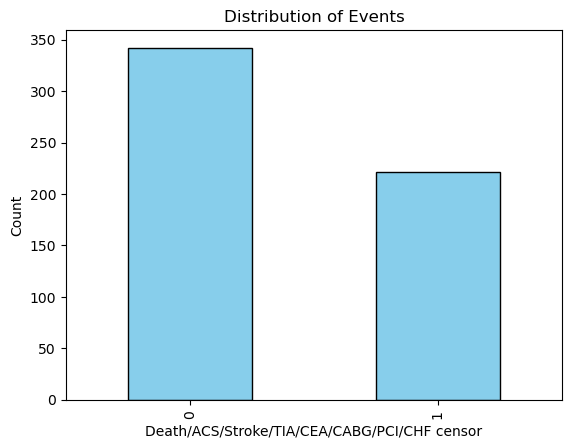

In [3]:
# Assuming the first column is the predictor column (you may need to adjust the column name accordingly)
predictor_column = df.columns[0]

# Visualize the ratio of events in the predictor column
event_counts = df[predictor_column].value_counts()
event_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel(predictor_column)
plt.ylabel('Count')
plt.title('Distribution of Events')
plt.show()

### Preprocessing and Feature Selection

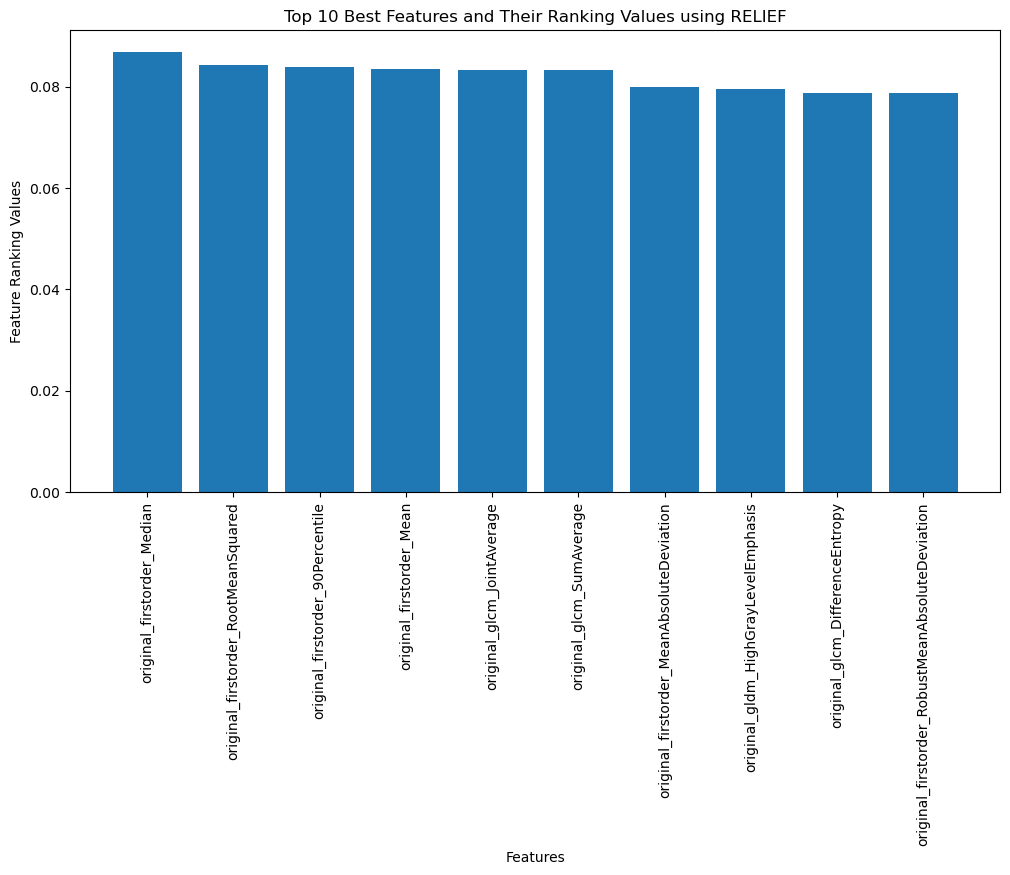

Top 10 Best Features:
original_firstorder_Median: 0.0868
original_firstorder_RootMeanSquared: 0.0843
original_firstorder_90Percentile: 0.0838
original_firstorder_Mean: 0.0835
original_glcm_JointAverage: 0.0832
original_glcm_SumAverage: 0.0832
original_firstorder_MeanAbsoluteDeviation: 0.0799
original_gldm_HighGrayLevelEmphasis: 0.0795
original_glcm_DifferenceEntropy: 0.0788
original_firstorder_RobustMeanAbsoluteDeviation: 0.0788


In [4]:
# Data preprocessing: clean the dataset and normalize numerical features
# Assuming all columns except the predictor column are numerical features
numerical_features = df.columns[1:]

# Clean the dataset by removing rows with missing values
df.dropna(inplace=True)

# Normalize the numerical features using StandardScaler
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Feature selection using RELIEF algorithm
X = df.drop(predictor_column, axis=1)
y = df[predictor_column]

# Instantiate the ReliefF class and fit the data
relief = ReliefF(n_features_to_select=10, n_neighbors=100)
relief.fit(X.values, y.values)

# Get the feature ranking values
feature_ranking_values = relief.feature_importances_

# Get the top 10 best features
selected_feature_indices = relief.top_features_[:10]  # Select only the top 10 features
selected_features = X.columns[selected_feature_indices]

# Visualize the top 10 best features and their ranking values
plt.figure(figsize=(12, 6))
plt.bar(range(len(selected_features)), feature_ranking_values[selected_feature_indices], tick_label=selected_features)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Ranking Values')
plt.title('Top 10 Best Features and Their Ranking Values using RELIEF')
plt.show()

# Print out the names of the top 10 best features along with their ranking values
print("Top 10 Best Features:")
for feature, ranking in zip(selected_features, feature_ranking_values[selected_feature_indices]):
    print(f"{feature}: {ranking:.4f}")

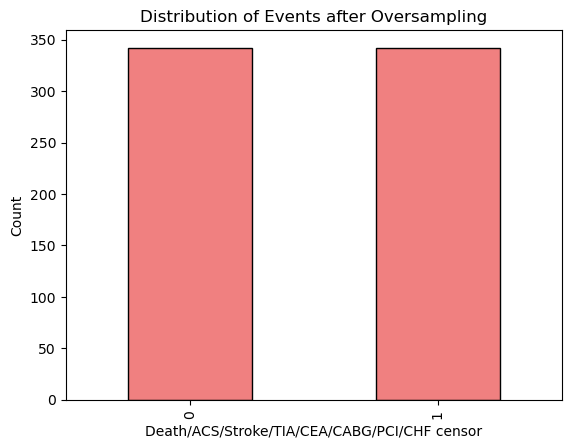

In [5]:
# Oversampling
# Instantiate the RandomOverSampler class
random_oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Perform oversampling on the dataset
X_resampled, y_resampled = random_oversampler.fit_resample(X, y)

# Create a new DataFrame with the oversampled data
oversampled_df = pd.concat([pd.DataFrame(X_resampled, columns=selected_features), pd.DataFrame(y_resampled, columns=[predictor_column])], axis=1)


# Visualize the ratio of events in the predictor column after oversampling
event_counts_oversampled = oversampled_df[predictor_column].value_counts()
event_counts_oversampled.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.xlabel(predictor_column)
plt.ylabel('Count')
plt.title('Distribution of Events after Oversampling')
plt.show()


### Machine Learning 

In [6]:
# # Convert X_resampled and y_resampled to DataFrames
# X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
# y_resampled_df = pd.Series(y_resampled, name=predictor_column)

# # Define a list of C values to test
# c_values = [0.1, 1, 10]

# # Define a list of K folds to use
# k_folds = [3, 5, 10]

# # Create a dictionary to store AUC scores for each combination of C value and K fold
# auc_scores = {}

# # Plot the ROC curve for each combination of C value and K fold
# plt.figure(figsize=(10, 8))

# for c_value in c_values:
#     for k in k_folds:
#         svm_classifier = SVC(C=c_value, probability=True)
#         cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        
#         mean_fpr = np.linspace(0, 1, 100)
#         tpr_sum = 0
        
#         for train_index, test_index in cv.split(X_resampled_df, y_resampled_df):
#             X_train, X_test = X_resampled_df.iloc[train_index], X_resampled_df.iloc[test_index]
#             y_train, y_test = y_resampled_df.iloc[train_index], y_resampled_df.iloc[test_index]

#             svm_classifier.fit(X_train, y_train)
#             y_prob = svm_classifier.predict_proba(X_test)[:, 1]
#             fpr, tpr, _ = roc_curve(y_test, y_prob)

#             # Interpolate the TPR values to get the same points for each fold
#             tpr_sum += np.interp(mean_fpr, fpr, tpr)

#         mean_tpr = tpr_sum / k
#         auc_val = auc(mean_fpr, mean_tpr)
#         auc_scores[(c_value, k)] = auc_val

#         plt.plot(mean_fpr, mean_tpr, label=f"C = {c_value}, K-Fold = {k}, AUC = {auc_val:.4f}")

# # Plot the diagonal line representing random guessing
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for SVM with Different C Values and K Folds')
# plt.legend(loc='lower right')
# plt.show()

# # Find the combination of C value and K fold with the highest AUC score
# best_combination = max(auc_scores, key=auc_scores.get)
# best_c_value, best_k_fold = best_combination

# # Plot the ROC curve for the best combination
# plt.figure(figsize=(10, 8))
# svm_classifier = SVC(C=best_c_value, probability=True)
# cv = StratifiedKFold(n_splits=best_k_fold, shuffle=True, random_state=42)

# mean_fpr = np.linspace(0, 1, 100)
# tpr_sum = 0

# for train_index, test_index in cv.split(X_resampled_df, y_resampled_df):
#     X_train, X_test = X_resampled_df.iloc[train_index], X_resampled_df.iloc[test_index]
#     y_train, y_test = y_resampled_df.iloc[train_index], y_resampled_df.iloc[test_index]

#     svm_classifier.fit(X_train, y_train)
#     y_prob = svm_classifier.predict_proba(X_test)[:, 1]
#     fpr, tpr, _ = roc_curve(y_test, y_prob)

#     # Interpolate the TPR values to get the same points for each fold
#     tpr_sum += np.interp(mean_fpr, fpr, tpr)

# mean_tpr = tpr_sum / best_k_fold
# best_auc_val = auc(mean_fpr, mean_tpr)

# plt.plot(mean_fpr, mean_tpr, label=f"Best C = {best_c_value}, Best K-Fold = {best_k_fold}, AUC = {best_auc_val:.4f}")

# # Plot the diagonal line representing random guessing
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for SVM with Best C Value and K Fold')
# plt.legend(loc='lower right')
# plt.show()

# # Print the best combination of C value and K fold
# print(f"Best Combination: C = {best_c_value}, K-Fold = {best_k_fold}, Best AUC = {best_auc_val:.4f}")

# # Print the AUC scores for each combination of C value and K fold
# print("AUC Scores:")
# for (c_value, k), auc_val in auc_scores.items():
#     print(f"C = {c_value}, K-Fold = {k}: AUC = {auc_val:.4f}")

C:\Users\mojta\AppData\Local\Temp\ipykernel_35852\3032340982.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_resampled_df.columns = X_resampled_df.columns.str.replace('[', '')
C:\Users\mojta\AppData\Local\Temp\ipykernel_35852\3032340982.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_resampled_df.columns = X_resampled_df.columns.str.replace(']', '')
C:\Users\mojta\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


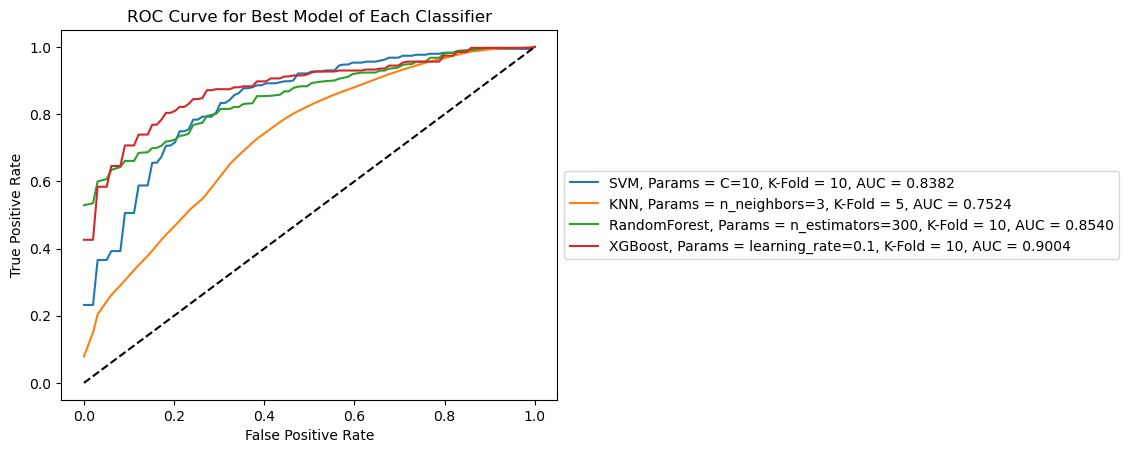

Best XGBoost Model, Params: learning_rate=0.1, K-Fold: 10, AUC: 0.9004, Precision: 0.8051 ± 0.0613, Recall: 0.8098 ± 0.0883, F1-Score: 0.8040 ± 0.0551, Accuracy: 0.8041 ± 0.0528
Best RandomForest Model, Params: n_estimators=300, K-Fold: 10, AUC: 0.8540, Precision: 0.7338 ± 0.0670, Recall: 0.7866 ± 0.0969, F1-Score: 0.7575 ± 0.0739, Accuracy: 0.7497 ± 0.0746
Best SVM Model, Params: C=10, K-Fold: 10, AUC: 0.8382, Precision: 0.7481 ± 0.0593, Recall: 0.8099 ± 0.0607, F1-Score: 0.7762 ± 0.0489, Accuracy: 0.7661 ± 0.0549
Best KNN Model, Params: n_neighbors=3, K-Fold: 5, AUC: 0.7524, Precision: 0.6952 ± 0.0414, Recall: 0.7340 ± 0.0160, F1-Score: 0.7135 ± 0.0253, Accuracy: 0.7047 ± 0.0310


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
from xgboost import XGBClassifier

X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.Series(y_resampled, name=predictor_column)

# Clean column names
X_resampled_df.columns = X_resampled_df.columns.str.replace('[', '')
X_resampled_df.columns = X_resampled_df.columns.str.replace(']', '')
X_resampled_df.columns = X_resampled_df.columns.str.replace('<', '')

# Define the classifiers
classifiers = {
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Define the hyperparameters for each classifier
hyperparameters = {
    'SVM': {'C': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'RandomForest': {'n_estimators': [100, 200, 300]},
    'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1]}
}

k_folds = [3, 5, 10]
results = {}

for name, classifier in classifiers.items():
    best_auc = 0
    best_params = None
    best_k = None
    best_precision = None
    best_recall = None
    best_f1_score = None
    best_accuracy = None
    for k in k_folds:
        cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        mean_fpr = np.linspace(0, 1, 100)
        for param_name, param_values in hyperparameters[name].items():
            for param_value in param_values:
                clf = classifier.set_params(**{param_name: param_value})
                tpr_sum = 0
                precision_scores = []
                recall_scores = []
                f1_scores = []
                accuracy_scores = []
                for train_index, test_index in cv.split(X_resampled_df, y_resampled_df):
                    X_train, X_test = X_resampled_df.iloc[train_index], X_resampled_df.iloc[test_index]
                    y_train, y_test = y_resampled_df.iloc[train_index], y_resampled_df.iloc[test_index]
                    clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)
                    y_prob = clf.predict_proba(X_test)[:, 1]
                    precision_scores.append(precision_score(y_test, y_pred))
                    recall_scores.append(recall_score(y_test, y_pred))
                    f1_scores.append(f1_score(y_test, y_pred))
                    accuracy_scores.append(accuracy_score(y_test, y_pred))
                    fpr, tpr, _ = roc_curve(y_test, y_prob)
                    tpr_sum += np.interp(mean_fpr, fpr, tpr)
                mean_tpr = tpr_sum / k
                auc_val = auc(mean_fpr, mean_tpr)
                if auc_val > best_auc:
                    best_auc = auc_val
                    best_params = f"{param_name}={param_value}"
                    best_k = k
                    best_precision = (np.mean(precision_scores), np.std(precision_scores))
                    best_recall = (np.mean(recall_scores), np.std(recall_scores))
                    best_f1_score = (np.mean(f1_scores), np.std(f1_scores))
                    best_accuracy = (np.mean(accuracy_scores), np.std(accuracy_scores))

    results[name] = {'Params': best_params, 'K-Fold': best_k, 'AUC': best_auc,
                     'Precision': best_precision, 'Recall': best_recall, 'F1-Score': best_f1_score, 'Accuracy': best_accuracy}
    
    plt.plot(mean_fpr, mean_tpr, label=f"{name}, Params = {best_params}, K-Fold = {best_k}, AUC = {best_auc:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Model of Each Classifier')

# Move the legend outside of the graph using bbox_to_anchor
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the figure as PNG without compression
plt.savefig('allData.png', dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()

# Print the sorted AUC scores
results_sorted = sorted(results.items(), key=lambda item: item[1]['AUC'], reverse=True)
for clf_name, metrics in results_sorted:
    print(f"Best {clf_name} Model, Params: {metrics['Params']}, K-Fold: {metrics['K-Fold']}, AUC: {metrics['AUC']:.4f}, Precision: {metrics['Precision'][0]:.4f} ± {metrics['Precision'][1]:.4f}, Recall: {metrics['Recall'][0]:.4f} ± {metrics['Recall'][1]:.4f}, F1-Score: {metrics['F1-Score'][0]:.4f} ± {metrics['F1-Score'][1]:.4f}, Accuracy: {metrics['Accuracy'][0]:.4f} ± {metrics['Accuracy'][1]:.4f}")